In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from copy import deepcopy
from numba import types as tps
from typing import Sequence, Tuple
from bisect import bisect_left
import torch.nn as nn
import torch
import time

from lobio.lob.limit_order import Order, AMOUNT_TICK, PRICE_TICK, EventType, OrderType, TraderId, Side
from lobio.lob.order_book import  OrderBook, OrderBookSimple, TOP_N, PriceLevelSimple
from lobio.utils.utils import group_diffs, group_historical_trades, group_orders, get_initial_order_book_trunc, \
                                get_initial_order_book_simple, get_initial_order_book_simple2
from lobio.models.reinforce_model import GaussianPDFModel

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
diffs_raw_file = "../data/diffs_raw.npy"
diffs_prepared_file = "../data/diffs_prepared.npy"
init_lob_raw_file = "../data/init_lob_raw.npy"
init_lob_prepared_file = "../data/init_lob_prepared.npy"
aggtrades_raw_file = "../data/aggtrades_raw.npy"
orders_prepared_file = "../data/orders_prepared.npy"
pl_to_enter_file = "../data/price_level_to_enter.npy"

with open(init_lob_raw_file, 'rb') as file:
    init_lob_raw = np.load(file)
with open(diffs_raw_file, 'rb') as file:
    diffs_raw = np.load(file)
with open(aggtrades_raw_file, 'rb') as file:
    aggtrades_raw = np.load(file)

with open(init_lob_prepared_file, 'rb') as file:
    init_lob = np.load(file)
with open(diffs_prepared_file, 'rb') as file:
    diffs = np.load(file)
with open(orders_prepared_file, 'rb') as file:
    orders = np.load(file)

with open(pl_to_enter_file, 'rb') as file:
    pl_to_enter = np.load(file)

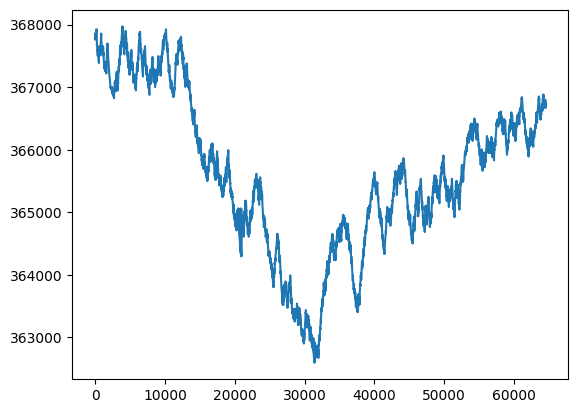

In [3]:
plt.plot(aggtrades_raw[:, 1])
plt.show()

In [4]:
diffs_grouped = group_diffs(diffs)
orders_per_diff = group_orders(orders, len(diffs_grouped))

100%|██████████| 23209/23209 [00:00<00:00, 70611.93it/s]


In [5]:
len(orders_per_diff), len(diffs_grouped)

(23209, 23209)

In [7]:
n_poses = len(pl_to_enter)

In [42]:
def run_true_simulation(samples: np.array, place_ratios: np.array, rng) -> list[None|Tuple[int, int]]:
    poses_true_info = [None] * len(samples)
    my_current_poses: dict[int, PriceLevelSimple] = {}
    sample_running_ind = 0
    ob = get_initial_order_book_simple2(init_lob)

    for i, diff in enumerate(diffs_grouped):
        while sample_running_ind < len(samples) and samples[sample_running_ind][0] == i:
            if samples[sample_running_ind][2] == Side.BUY:
                ind = bisect_left(ob.bids, -samples[sample_running_ind][1], key=lambda x: -x.base)
                if ob.bids[ind].my_order_id != None:
                    my_current_poses.pop(ob.bids[ind].my_order_id)
                    poses_true_info[ob.bids[ind].my_order_id] = -1 # THINK

                ob.bids[ind].place_my_order(place_ratios[sample_running_ind], sample_running_ind)
                my_current_poses[sample_running_ind] = ob.bids[ind]
            else:
                ind = bisect_left(ob.asks, samples[sample_running_ind][1], key=lambda x: x.base)
                if ob.asks[ind].my_order_id != None:
                    my_current_poses.pop(ob.asks[ind].my_order_id)
                    poses_true_info[ob.asks[ind].my_order_id] = -1 # THINK

                ob.asks[ind].place_my_order(place_ratios[sample_running_ind], sample_running_ind)
                my_current_poses[sample_running_ind] = ob.asks[ind]

            sample_running_ind += 1

        cur_orders = orders_per_diff[i]
        for j, (_, order) in enumerate(cur_orders):
            if order.type == OrderType.MARKET:
                my_orders_eaten = ob.set_market_order([order.quote, order.side])
                for my_eaten in my_orders_eaten:
                    poses_true_info[my_eaten] = (i, j)
                    my_current_poses.pop(my_eaten)
            else:
                ob.set_limit_order([order.base, order.quote, order.side])

        ratios = rng.beta(1.5, 12, size=len(my_current_poses))
        for j, p_l in enumerate(my_current_poses.values()):
            p_l.queue_dynamic(ratios[j])

        my_orders_removed = ob.apply_historical_update(diff)
        for my_removed in my_orders_removed:
            my_current_poses.pop(my_removed)
    
    return poses_true_info

In [43]:
def run_pred_simulation(samples: np.array, place_ratios: np.array, rl_model) -> Tuple[list[None|Tuple[int, int]],
                                                                                        list[list[Tuple[int, int, int]]]]:
    poses_pred_info = [None] * len(samples)
    my_current_poses_info: dict[int, Tuple[PriceLevelSimple, int, int, int]] = {} # order_id - price level, number of diffs lived,amount changed, old_amount
    obs_actions = [[] for _ in range(len(samples))]
    sample_running_ind = 0
    ob = get_initial_order_book_simple2(init_lob)

    for i, diff in enumerate(diffs_grouped):
        while sample_running_ind < len(samples) and samples[sample_running_ind][0] == i:
            if samples[sample_running_ind][2] == Side.BUY:
                ind = bisect_left(ob.bids, -samples[sample_running_ind][1], key=lambda x: -x.base) # INDEXES FOUND IN PREV STEP(WHILE GROUND TRUE GENERATED)
                if ob.bids[ind].my_order_id != None:
                    my_current_poses_info.pop(ob.bids[ind].my_order_id)
                    poses_pred_info[ob.bids[ind].my_order_id] = -1 # THINK

                ob.bids[ind].place_my_order(place_ratios[sample_running_ind], sample_running_ind)
                my_current_poses_info[sample_running_ind] = [ob.bids[ind], 0, 0, ob.bids[ind].total_amount()]
            else:
                ind = bisect_left(ob.asks, samples[sample_running_ind][1], key=lambda x: x.base)
                if ob.asks[ind].my_order_id != None:
                    my_current_poses_info.pop(ob.asks[ind].my_order_id)
                    poses_pred_info[ob.asks[ind].my_order_id] = -1 # THINK

                ob.asks[ind].place_my_order(place_ratios[sample_running_ind], sample_running_ind)
                my_current_poses_info[sample_running_ind] = [ob.asks[ind], 0, 0, ob.asks[ind].total_amount()]

            sample_running_ind += 1

        cur_orders = orders_per_diff[i]
        for j, (_, order) in enumerate(cur_orders):
            if order.type == OrderType.MARKET:
                my_orders_eaten = ob.set_market_order([order.quote, order.side])
                for my_eaten in my_orders_eaten:
                    poses_pred_info[my_eaten] = (i, j)
                    my_current_poses_info.pop(my_eaten)
            else:
                ob.set_limit_order([order.base, order.quote, order.side])

        observations = []
        for info in my_current_poses_info.values():
            observations.append((info[1], info[2]))

        if len(observations):
            observations_tensor = torch.FloatTensor(observations)
            ratios = rl_model.sample(observations_tensor)
            for j, (order_id, info) in enumerate(my_current_poses_info.items()):
                info[0].queue_dynamic(ratios[j])
                obs_actions[order_id].append((info[1], info[2], ratios[j]))

        my_orders_removed = ob.apply_historical_update(diff)
        for my_removed in my_orders_removed:
            my_current_poses_info.pop(my_removed)

        for info in my_current_poses_info.values():
            info[1] += 1
            info[2] += info[0].total_amount() - info[3]
            info[3] = info[0].total_amount()
    
    return poses_pred_info, obs_actions

In [44]:
def calculate_loss(poses_true_info: list[None|Tuple[int, int]], poses_pred_info: list[None|Tuple[int, int]], 
                   obs_actions: list[list[Tuple[int, int, int]]], gamma, rl_model) -> torch.FloatTensor:
    max_len = 0
    all_episod_records = []
    for episod_record in obs_actions:
        if len(episod_record) > max_len:
            max_len = len(episod_record)
        
        all_episod_records.append(torch.tensor(episod_record))
    
    all_episod_records = torch.concat(all_episod_records, dim=0)
    all_log_probs = rl_model.log_probs(all_episod_records)

    loss = 0
    M = 0
    coefs = gamma**torch.arange(0, max_len)
    cum_sum = torch.cumsum(coefs, dim=0)
    re_cum_sum = coefs - cum_sum + cum_sum[-1:None]
    running_idx = 0
    for i, episod_record in enumerate(obs_actions):
        #if not (poses_true_info[i] == poses_pred_info[i] == None):
        if not (poses_true_info[i] == poses_pred_info[i] == -1):
            if len(episod_record):
                episod_reward = 2 * (poses_true_info[i] != poses_pred_info[i]) - 1
                loss += episod_reward * (re_cum_sum[:len(episod_record)] * all_log_probs[running_idx:running_idx+len(episod_record)]).sum() / len(episod_record)
                M += 1
        running_idx += len(episod_record)

    loss /= M

    return loss

In [72]:
rng = np.random.default_rng()
dim_observation=2
dim_action = 1
rl_model = GaussianPDFModel(
    dim_observation=dim_observation,
    dim_action=dim_action,
    action_bounds=np.array([[0, 1]]),
    scale_factor=10,
    dim_hidden=8,
    std=0.001,
)
gamma = 0.99
lr = 0.005
optimizer = torch.optim.SGD(rl_model.parameters(), lr=lr)
N_iter = 50

In [73]:
running_loss = [None]
for i in tqdm(range(N_iter)):
    samples_ind = np.unique(np.random.randint(0, n_poses, size=1000))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples)) # FIXED

    optimizer.zero_grad()
    poses_true_info = run_true_simulation(samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(samples, place_ratios, rl_model)
    loss = calculate_loss(poses_true_info, poses_pred_info, obs_actions, gamma, rl_model)
    running_loss.append(loss.item())
    #print(running_loss[-1])
    loss.backward()
    optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [05:47<00:00,  6.96s/it]


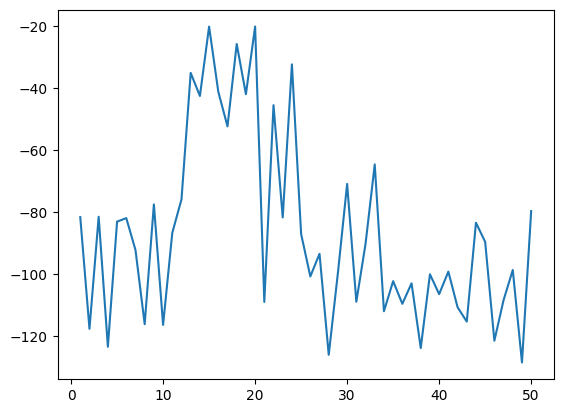

In [74]:
plt.plot(running_loss) # 8 hid dim
plt.show()

In [75]:
rl_model

GaussianPDFModel(
  (perceptron): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

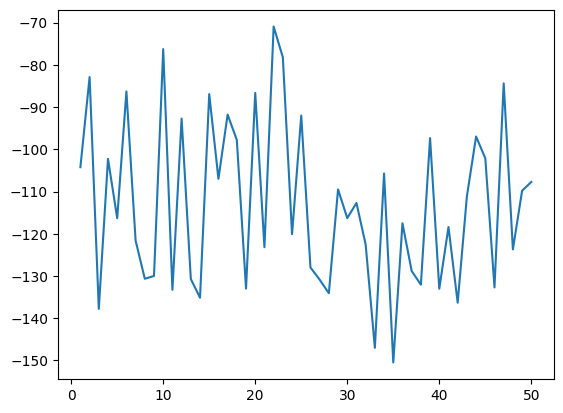

In [70]:
plt.plot(running_loss) # lin reg
plt.show()

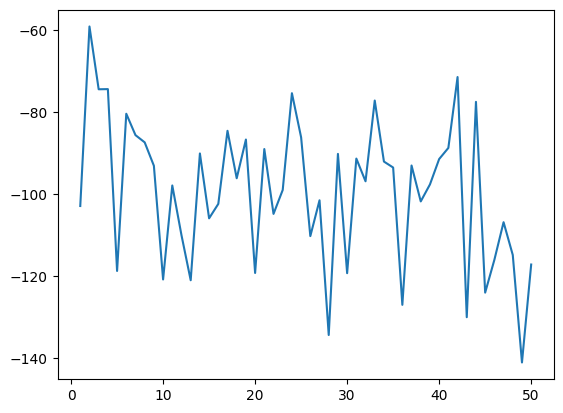

In [65]:
plt.plot(running_loss) # lin reg
plt.show()

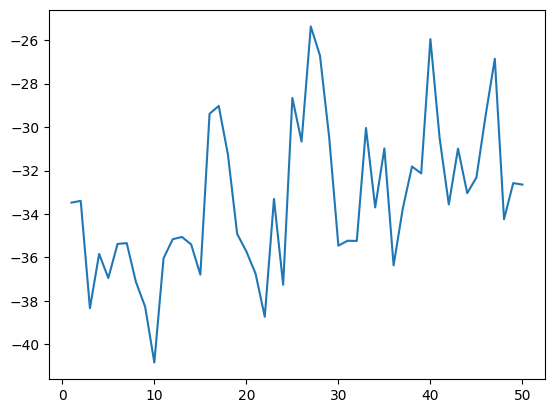

In [62]:
plt.plot(running_loss) # 16!
plt.show()

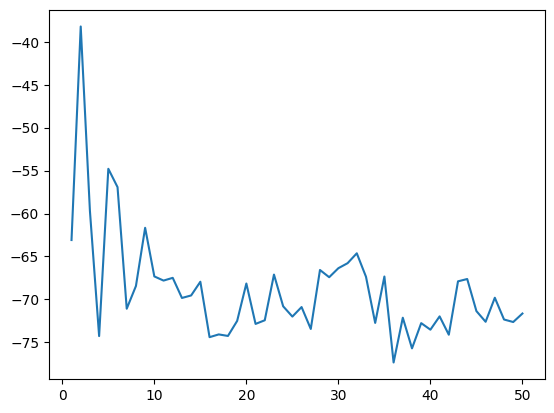

In [59]:
plt.plot(running_loss)
plt.show()

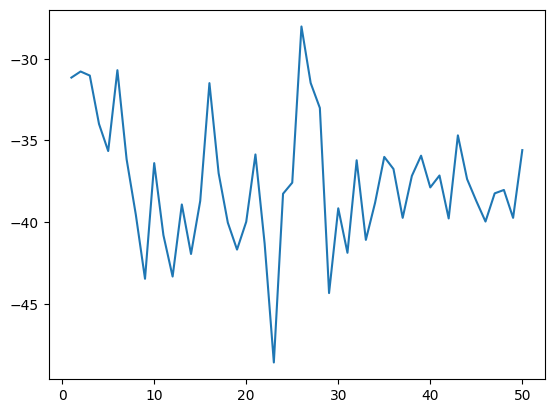

In [52]:
plt.plot(running_loss) # fixed free reward
plt.show()

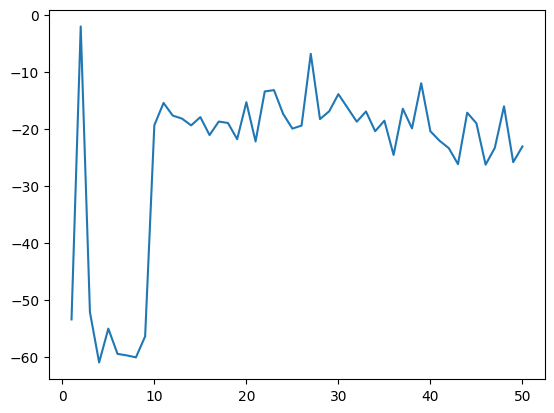

In [36]:
plt.plot(running_loss) # lr 0.005 Nones removed
plt.show()

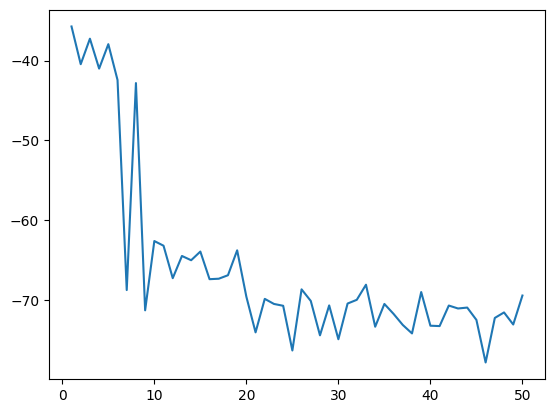

In [28]:
plt.plot(running_loss) # lr 0.005
plt.show()

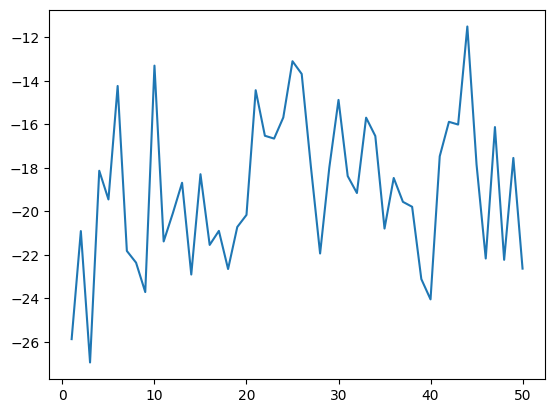

In [24]:
plt.plot(running_loss) # lr 0.01
plt.show()

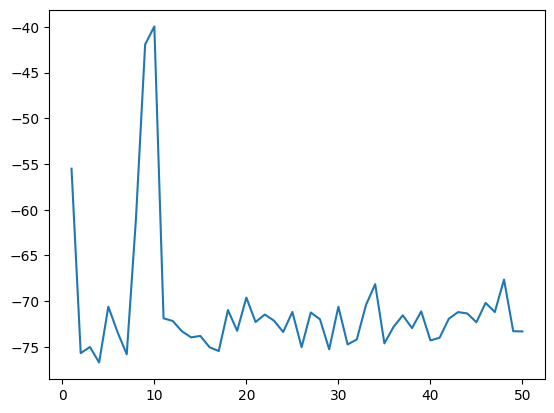

In [21]:
plt.plot(running_loss)# - rew
plt.show()

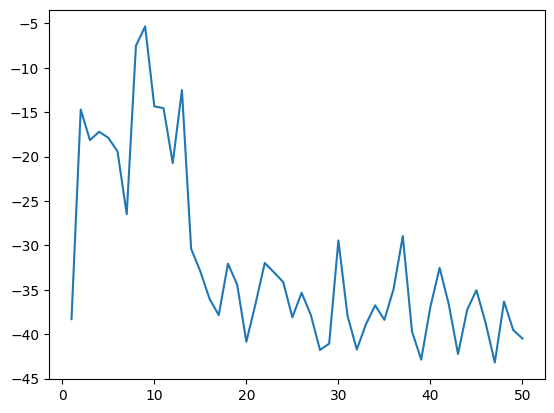

In [13]:
plt.plot(running_loss)
plt.show()

In [22]:
samples_ind = np.unique(np.random.randint(0, n_poses, size=1000))
samples_ind.sort()
samples = pl_to_enter[samples_ind]
place_ratios = rng.triangular(0, 0.1, 1, size=len(samples))

poses_true_info = run_true_simulation(samples, place_ratios, rng)
poses_pred_info, obs_actions = run_pred_simulation(samples, place_ratios, rl_model)
loss = calculate_loss(poses_true_info, poses_pred_info, obs_actions, gamma, rl_model)

print(loss)

tensor(-1.9954, grad_fn=<DivBackward0>)


In [357]:
for ind, p_l in enumerate(ob2.asks):
    assert p_l[0] == ob.asks[ind].base
    assert p_l[1] == ob.asks[ind].total_amount()

for ind, p_l in enumerate(ob2.bids):
    assert p_l[0] == ob.bids[ind].base
    assert p_l[1] == ob.bids[ind].total_amount()

100%|██████████| 20/20 [00:00<00:00, 23871.96it/s]


In [223]:
pl_to_enter # filter? remove those who live 1-2 diffs

array([[     0, 367769,      1],
       [     0, 367798,      1],
       [     2, 367766,     -1],
       ...,
       [ 23173, 366702,      1],
       [ 23175, 366750,      1],
       [ 23195, 366749,     -1]])

In [512]:
tmp = range(10)

In [513]:
rng = np.random.default_rng()

In [526]:
times_tr = []
for _ in range(10**5):
    start = time.time_ns()
    q = rng.beta(1.5, 12, size=len(tmp))
    for j, i in enumerate(tmp):
        q[j]
    end = time.time_ns()
    times_tr.append(end - start)

times_uni = []
for _ in range(10**5):
    start = time.time_ns()
    for i in tmp:
        rng.beta(1.5, 12)
    end = time.time_ns()
    times_uni.append(end - start)

In [527]:
np.mean(times_tr), np.std(times_tr)

(5301.56705, 11377.838603988204)

In [528]:
np.mean(times_uni), np.std(times_uni)

(14785.18414, 77330.03937265539)

In [135]:
rng.triangular(0, 0.15, 1)

0.3931968057873262

In [45]:
diffs_prep_grouped = group_diffs(diffs)
orders_prep_grouped = group_orders(orders, len(diffs_prep_grouped))

  0%|          | 0/23163 [00:00<?, ?it/s]

100%|██████████| 23163/23163 [00:00<00:00, 256035.48it/s]


In [60]:
# ob1 = get_initial_order_book_simple(init_lob_prepared)
# ob2 = get_initial_order_book_simple(init_lob_prepared)

# for i, diff in enumerate(tqdm(diffs_prep_grouped)):
#     cur_orders = orders_prep_grouped[i]
#     for ts, order in cur_orders:
#         if order.type == OrderType.MARKET:
#             ob1.set_market_order([order.quote, order.side])
#             ob2.set_market_order([order.quote, order.side])
#         else:
#             ob1.set_limit_order([order.base, order.quote, order.side])
#             ob2.set_limit_order([order.base, order.quote, order.side])

#     ob1.apply_historical_update(diff)
#     ob2.apply_historical_update(diffs_cut[i])
#     del ob2.bids[TOP_N:]
#     del ob2.asks[TOP_N:]

#     assert ob1.bids[:TOP_N] == ob2.bids[:TOP_N]
#     assert ob1.asks[:TOP_N] == ob2.asks[:TOP_N]

100%|██████████| 23209/23209 [00:15<00:00, 1547.09it/s]


In [50]:
# diffs_grouped = group_diffs(diffs_raw)
# diffs_prep_grouped = group_diffs(diffs)
# orders_prep_grouped = group_orders(orders, len(diffs_prep_grouped))

# ob1 = get_initial_order_book_simple(init_lob)
# ob2 = get_initial_order_book_simple(init_lob_raw)

# for i, diff in enumerate(tqdm(diffs_prep_grouped)):
#     cur_orders = orders_prep_grouped[i]
#     for ts, order in cur_orders:
#         if order.type == OrderType.MARKET:
#             ob1.set_market_order([order.quote, order.side])
#         else:
#             ob1.set_limit_order([order.base, order.quote, order.side])
    
#     ob1.apply_historical_update(diff)
#     ob2.apply_historical_update(diffs_grouped[i])

# assert ob1 == ob2

100%|██████████| 23209/23209 [00:25<00:00, 922.29it/s] 


In [30]:
# ob1 = get_initial_order_book_simple(init_lob)
# ob1.top_n = 500
# ob2 = get_initial_order_book_simple(init_lob)
# ob2.top_n = 200
# mid_prices1 = []
# mid_prices2 = []
# for i, diff in enumerate(tqdm(diffs_prep_grouped)):
#     cur_orders = orders_prep_grouped[i]
#     for ts, order in cur_orders:
#         if order.type == OrderType.MARKET:
#             ob2.set_market_order([order.quote, order.side])
#             ob1.set_market_order([order.quote, order.side])
#         else:
#             ob2.set_limit_order([order.base, order.quote, order.side])
#             ob1.set_limit_order([order.base, order.quote, order.side])
#     ob2.apply_historical_update(diff)
#     ob1.apply_historical_update(diff)
#     mid_prices1.append(ob1.bids[0][0] + ob1.asks[0][0])
#     mid_prices2.append(ob2.bids[0][0] + ob2.asks[0][0])
#     # assert ob1.bids[:10] == ob2.bids[:10]
#     # assert ob1.asks[:10] == ob2.asks[:10]

  0%|          | 0/23209 [00:00<?, ?it/s]

100%|██████████| 23209/23209 [00:11<00:00, 2027.36it/s]


In [31]:
# dif_ind = []
# for i, pr in enumerate(mid_prices1):
#     if pr != mid_prices2[i]:
#         dif_ind.append(i)

In [32]:
# len(dif_ind)

10

In [6]:
diffs_grouped = group_diffs(diffs_raw)

100%|██████████| 23209/23209 [00:02<00:00, 8249.07it/s] 


In [8]:
bid_downs = []
ask_ups = []

for diff in diffs_grouped:
    cur_bid_down = 0
    cur_ask_up = 0
    for bid in diff[1]:
        if bid[1] == 0:
            cur_bid_down += 1
        else:
            break
    
    for ask in diff[2]:
        if ask[1] == 0:
            cur_ask_up += 1
        else:
            break
    
    bid_downs.append(cur_bid_down)
    ask_ups.append(cur_ask_up)

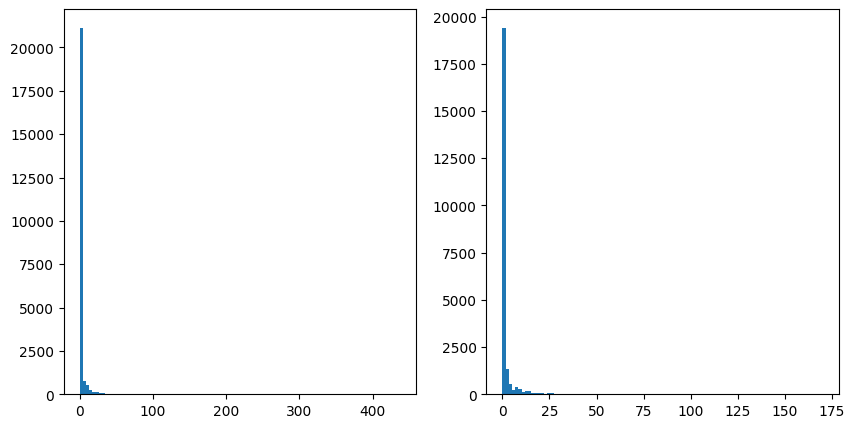

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(bid_downs, bins=100)
axes[1].hist(ask_ups, bins=100)

plt.show()

In [12]:
print(np.max(bid_downs), np.median(bid_downs), np.mean(bid_downs))
print(np.max(ask_ups), np.median(ask_ups), np.mean(ask_ups))

437 0.0 1.7195053642983325
170 0.0 1.5846008014132449


In [6]:
diffs_grouped = group_diffs(diffs_raw)
diffs_prepared_grouped = group_diffs(diffs)
trades_grouped = group_historical_trades(aggtrades_raw, diffs_grouped)

In [8]:
buy_moves = []
sell_moves = []

for i, cur_trades in enumerate(trades_grouped):
    cur_buy_prices = []
    cur_sell_prices = []
    for trade in cur_trades:
        if trade[3] == Side.BUY:
            cur_buy_prices.append(trade[1])
        else:
            cur_sell_prices.append(trade[1])
    
    if len(cur_buy_prices):
        buy_moves.append(np.max(cur_buy_prices) - np.min(cur_buy_prices))
    else:
        buy_moves.append(0)

    if len(cur_sell_prices):
        sell_moves.append(np.max(cur_sell_prices) - np.min(cur_sell_prices))
    else:
        sell_moves.append(0)

In [9]:
np.argmax(buy_moves), np.argmax(sell_moves), np.max(buy_moves), np.max(sell_moves)

(7359, 7360, 473, 705)

In [13]:
bids_updates_lens = []
asks_updates_lens = []

for diff in diffs_grouped:
    bids_updates_lens.append(len(diff[1]))
    asks_updates_lens.append(len(diff[2]))

bids2_updates_lens = []
asks2_updates_lens = []

for diff in diffs_prepared_grouped:
    bids2_updates_lens.append(len(diff[1]))
    asks2_updates_lens.append(len(diff[2]))

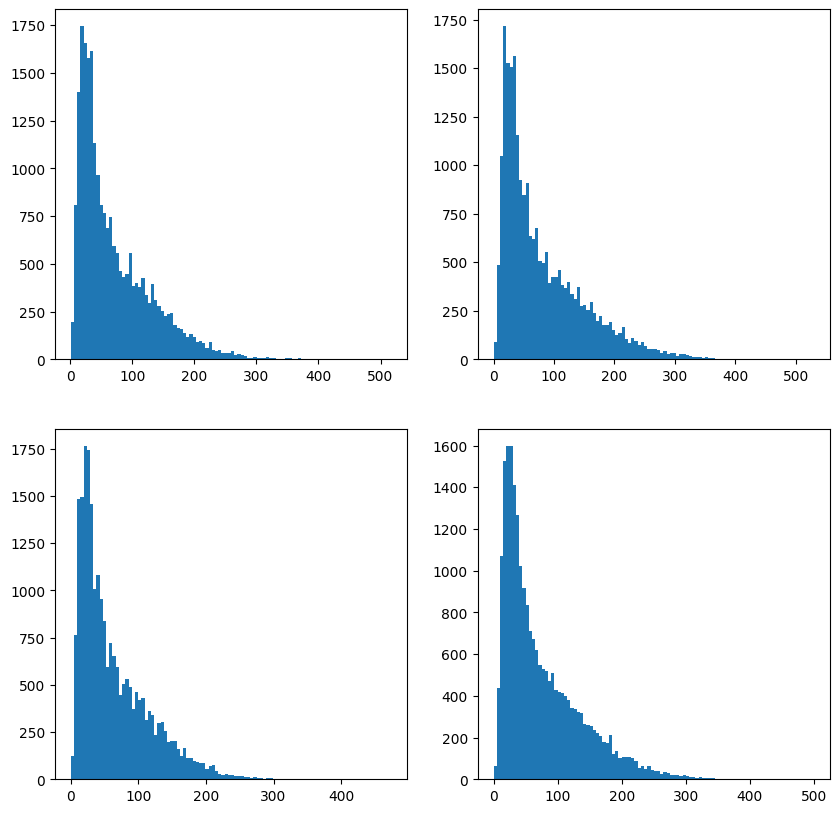

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].hist(bids_updates_lens, bins=100)
axes[0][1].hist(asks_updates_lens, bins=100)
axes[1][0].hist(bids2_updates_lens, bins=100)
axes[1][1].hist(asks2_updates_lens, bins=100)

plt.show()